In [1]:
import numpy as np 
import os
import tensorflow  as tf
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,UpSampling2D,InputLayer,Reshape

from keras.utils import image_dataset_from_directory
from keras.layers import Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
import matplotlib.pyplot as plt

from keras.layers import LeakyReLU
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import Bunch
import math
import pandas as pd
import datetime
import time
import csv
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import time
import datetime
import os
from PIL import Image
import sys

In [2]:
# 設定圖片大小和路徑
img_rows, img_cols = 256,256  # 縮小圖片尺寸以減少記憶體使用
train_data_dir = "C:/Users/user/Desktop/MLwork2/train"
test_data_dir = "C:/Users/user/Desktop/MLwork2/test"

In [3]:
# 準備測試不同的參數
epochs_list = [20,40,60]
batch_size_list = [8, 16]

In [4]:
# 對每種參數組合進行實驗
results = {}  # 用來存儲所有結果的字典
output_dir = 'C:/Users/user/Desktop/MLWORK/original'
csv_filename = 'original_training_results.csv'
detailed_csv_filename = os.path.join(output_dir, 'original_detailed_training_results.csv')
summary_csv_filename = os.path.join(output_dir, 'original_summary_results.csv')
plot_filename = os.path.join(output_dir, 'original_training_comparison.png')

os.makedirs(output_dir, exist_ok=True)

# 創建基本CSV文件並寫入標題
fieldnames = ['epochs', 'batch_size', 'train_acc', 'val_acc', 'test_acc', 
              'train_loss', 'val_loss', 'test_loss', 'training_time', 
              'overall_accuracy', 'men_accuracy', 'women_accuracy']

# 創建基本結果CSV
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# 創建詳細結果CSV (每個epoch的數據)
with open(detailed_csv_filename, 'w', newline='') as csvfile:
    detailed_fieldnames = ['combination', 'epoch', 'train_acc', 'val_acc', 'train_loss', 'val_loss']
    writer = csv.DictWriter(csvfile, fieldnames=detailed_fieldnames)
    writer.writeheader()

In [5]:
# 這邊只是輸出模型架構不然後面寫在迴圈裡會輸出很多次
reference_model = Sequential()

reference_model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_rows,img_cols,3)))
reference_model.add(Activation("relu"))
reference_model.add(MaxPooling2D(pool_size=(3,3)))

reference_model.add(Conv2D(64, (3,3), padding="same"))
reference_model.add(Activation("relu"))

reference_model.add(Conv2D(64, (3,3), padding="same"))
reference_model.add(Activation("relu"))
reference_model.add(MaxPooling2D(pool_size=(2,2)))


reference_model.add(Conv2D(128, (3,3), padding="same"))
reference_model.add(Activation("relu"))


reference_model.add(Conv2D(128, (3,3), padding="same"))
reference_model.add(Activation("relu"))
reference_model.add(MaxPooling2D(pool_size=(2,2)))

reference_model.add(Flatten())
reference_model.add(Dense(1024, activation='relu'))
reference_model.add(Dense(1, activation='sigmoid'))

# 只顯示一次模型摘要
print("\n模型架構:")
reference_model.summary()


模型架構:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 85, 85, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 64)        36928     
                                                 

In [6]:
# 對每種參數組合進行實驗
for epochs in epochs_list:
    for batch_size in batch_size_list:
        print(f"\n開始訓練 - epochs: {epochs}, batch_size: {batch_size}")
        
        # 資料增強和標準化
        train_datagen = ImageDataGenerator(
            validation_split=0.2,
            rescale=1./255,
        )
        
        validation_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=True,
            subset='training'
        )
        
        validation_generator = train_datagen.flow_from_directory(
            train_data_dir,
            batch_size=batch_size,
            target_size=(img_rows, img_cols),
            class_mode='binary',
            shuffle=True,
            subset='validation'
        )
        
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        # 模型
        model = Sequential()
        
        model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_rows,img_cols,3)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(3,3)))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))

        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))


        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))


        model.add(Conv2D(128, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))


        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy']
        )
        
        # 記錄時間
        start_time = time.time()
        
        # 訓練模型
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size
        )
        
        # 計算時間
        end_time = time.time()
        training_time = end_time - start_time
        formatted_time = str(datetime.timedelta(seconds=int(training_time)))
        
        # 在測試集上評估模型
        test_loss, test_acc = model.evaluate(
            test_generator,
            steps=test_generator.samples // batch_size + 1
        )
        
        # 計算每個類別的準確率
        y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()
        
        # 獲取真實標籤
        test_generator.reset()
        y_true = test_generator.classes
        
         # 計算整體準確率（不分性別）
        overall_accuracy = np.mean(y_pred_classes == y_true)
        
        # 計算每個類別的準確率
        class_accuracies = {}
        for class_idx, class_name in enumerate(test_generator.class_indices.keys()):
            # 找出屬於該類別的樣本
            class_samples = np.where(y_true == class_idx)[0]
            if len(class_samples) > 0:
                # 計算該類別的準確率
                class_correct = np.sum(y_pred_classes[class_samples] == class_idx)
                class_accuracy = class_correct / len(class_samples)
                class_accuracies[class_name] = class_accuracy
            else:
                class_accuracies[class_name] = 0.0
        
        # 獲取最終訓練和驗證準確率/損失
        final_train_acc = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_acc = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else None
        final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history else None
        
        # 儲存結果
        key = f"epochs_{epochs}_batch_{batch_size}"
        results[key] = {
            'history': history.history,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'training_time': training_time,
            'formatted_time': formatted_time,
            'overall_accuracy': overall_accuracy,
            'class_accuracies': class_accuracies,
            'train_acc': final_train_acc,
            'train_loss': final_train_loss,
            'val_acc': final_val_acc,
            'val_loss': final_val_loss
        }
        
        # 輸出當前實驗結果
        print(f"\n訓練完成 - epochs: {epochs}, batch_size: {batch_size}")
        print(f"訓練集準確率: {final_train_acc:.4f}, 損失: {final_train_loss:.4f}")
        print(f"驗證集準確率: {final_val_acc:.4f}, 損失: {final_val_loss:.4f}")
        print(f"測試集準確率: {test_acc:.4f}, 損失: {test_loss:.4f}")
        print(f"整體準確率(不分性別): {overall_accuracy:.4f}")
        print(f"訓練時間: {formatted_time}")
        print("各類別準確率:")
        for class_name, accuracy in class_accuracies.items():
            print(f"  {class_name}: {accuracy:.4f}")
            
        # 將結果寫入CSV
        with open(csv_filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({
                'epochs': epochs,
                'batch_size': batch_size,
                'train_acc': f"{final_train_acc:.4f}",
                'val_acc': f"{final_val_acc:.4f}" if final_val_acc is not None else None,
                'test_acc': f"{test_acc:.4f}",
                'train_loss': f"{final_train_loss:.4f}",
                'val_loss': f"{final_val_loss:.4f}" if final_val_loss is not None else None,
                'test_loss': f"{test_loss:.4f}",
                'training_time': formatted_time,
                'overall_accuracy': f"{overall_accuracy:.4f}",
                'men_accuracy': f"{class_accuracies.get('men', 0.0):.4f}",
                'women_accuracy': f"{class_accuracies.get('women', 0.0):.4f}"
            })
            
        # 保存每個epoch的詳細資訊
        with open(detailed_csv_filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=detailed_fieldnames)
            for i in range(len(history.history['accuracy'])):
                writer.writerow({
                    'combination': key,
                    'epoch': i+1,
                    'train_acc': f"{history.history['accuracy'][i]:.4f}",
                    'val_acc': f"{history.history['val_accuracy'][i]:.4f}" if 'val_accuracy' in history.history else None,
                    'train_loss': f"{history.history['loss'][i]:.4f}",
                    'val_loss': f"{history.history['val_loss'][i]:.4f}" if 'val_loss' in history.history else None
                })



開始訓練 - epochs: 20, batch_size: 8
Found 176 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Epoch 1/20
22/22 [==============================] - 15s 504ms/step - loss: 0.7282 - accuracy: 0.5170 - val_loss: 0.6923 - val_accuracy: 0.5250
Epoch 2/20
22/22 [==============================] - 10s 464ms/step - loss: 0.6927 - accuracy: 0.4886 - val_loss: 0.6929 - val_accuracy: 0.5500
Epoch 3/20
22/22 [==============================] - 11s 481ms/step - loss: 0.6845 - accuracy: 0.5682 - val_loss: 0.6902 - val_accuracy: 0.5500
Epoch 4/20
22/22 [==============================] - 11s 482ms/step - loss: 0.6657 - accuracy: 0.6193 - val_loss: 0.6791 - val_accuracy: 0.5750
Epoch 5/20
22/22 [==============================] - 11s 493ms/step - loss: 0.6130 - accuracy: 0.6420 - val_loss: 0.7087 - val_accuracy: 0.4250
Epoch 6/20
22/22 [==============================] - 11s 512ms/step - loss: 0.5300 - accuracy: 0.7500 - val_loss: 0.6806 - val_accu

In [7]:
# 創建並展示結果摘要
print("\n實驗結果摘要:")
print("-" * 132)
print(f"{'參數組合':<20}{'訓練準確率':<12}{'驗證準確率':<12}{'測試準確率':<12}{'訓練損失':<12}{'驗證損失':<12}{'測試損失':<12}{'訓練時間':<12}{'整體準確率':<12}{'men準確率':<12}{'women準確率':<12}")
print("-" * 132)


實驗結果摘要:
------------------------------------------------------------------------------------------------------------------------------------
參數組合                訓練準確率       驗證準確率       測試準確率       訓練損失        驗證損失        測試損失        訓練時間        整體準確率       men準確率      women準確率    
------------------------------------------------------------------------------------------------------------------------------------


In [8]:
for key, data in results.items():
    print(f"{key:<20}{data['train_acc']:.4f}{'':<4}{data['val_acc']:.4f}{'':<4}{data['test_acc']:.4f}{'':<4}{data['train_loss']:.4f}{'':<4}{data['val_loss']:.4f}{'':<4}{data['test_loss']:.4f}{'':<4}{data['formatted_time']:<12}{data['overall_accuracy']:.4f}{'':<4}{data['class_accuracies'].get('men', 0.0):.4f}{'':<4}{data['class_accuracies'].get('women', 0.0):.4f}")

# 將結果也輸出為DataFrame格式
summary_data = []
for key, data in results.items():
    epochs, batch_size = key.split('_')[1], key.split('_')[3]
    summary_data.append({
        'Epochs': epochs,
        'Batch Size': batch_size,
        'Train Accuracy': f"{data['train_acc']:.4f}",
        'Val Accuracy': f"{data['val_acc']:.4f}" if data['val_acc'] is not None else "N/A",
        'Test Accuracy': f"{data['test_acc']:.4f}",
        'Train Loss': f"{data['train_loss']:.4f}",
        'Val Loss': f"{data['val_loss']:.4f}" if data['val_loss'] is not None else "N/A",
        'Test Loss': f"{data['test_loss']:.4f}",
        'Training Time': data['formatted_time'],
        'Overall Accuracy': f"{data['overall_accuracy']:.4f}",
        'Men Accuracy': f"{data['class_accuracies'].get('men', 0.0):.4f}",
        'Women Accuracy': f"{data['class_accuracies'].get('women', 0.0):.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n以DataFrame格式的摘要:")
print(summary_df)

# 保存摘要為CSV
summary_df.to_csv(summary_csv_filename, index=False)

epochs_20_batch_8   1.0000    0.4250    0.5000    0.0015    3.6506    2.1837    0:03:43     0.5000    0.4750    0.5250
epochs_20_batch_16  1.0000    0.3750    0.5375    0.0057    3.0790    2.0338    0:03:39     0.5375    0.5500    0.5250
epochs_40_batch_8   1.0000    0.5250    0.6000    0.0001    3.9149    2.7745    0:07:10     0.6000    0.5750    0.6250
epochs_40_batch_16  1.0000    0.5000    0.5500    0.0004    3.5253    3.0345    0:07:15     0.5500    0.5500    0.5500
epochs_60_batch_8   1.0000    0.5000    0.6125    0.0000    4.1798    2.9921    0:10:47     0.6125    0.6250    0.6000
epochs_60_batch_16  1.0000    0.5000    0.5750    0.0003    3.0702    3.2723    0:10:35     0.5750    0.5250    0.6250

以DataFrame格式的摘要:
  Epochs Batch Size Train Accuracy Val Accuracy Test Accuracy Train Loss  \
0     20          8         1.0000       0.4250        0.5000     0.0015   
1     20         16         1.0000       0.3750        0.5375     0.0057   
2     40          8         1.0000      

參數組合 'epochs_20_batch_8' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_20_batch_8.png
參數組合 'epochs_20_batch_16' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_20_batch_16.png
參數組合 'epochs_40_batch_8' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_40_batch_8.png
參數組合 'epochs_40_batch_16' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_40_batch_16.png
參數組合 'epochs_60_batch_8' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_60_batch_8.png
參數組合 'epochs_60_batch_16' 的訓練過程圖表已保存至: C:/Users/user/Desktop/MLWORK/original\original_training_epochs_60_batch_16.png

所有參數組合的結果也已保存至: original_training_results.csv, C:/Users/user/Desktop/MLWORK/original\original_detailed_training_results.csv, C:/Users/user/Desktop/MLWORK/original\original_summary_results.csv


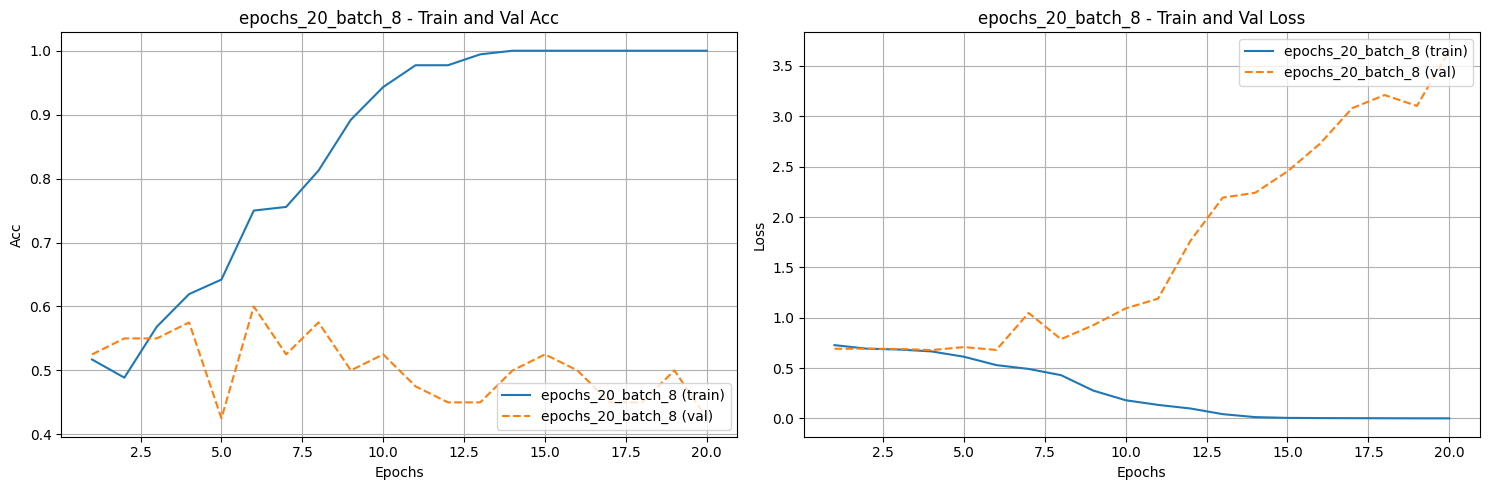

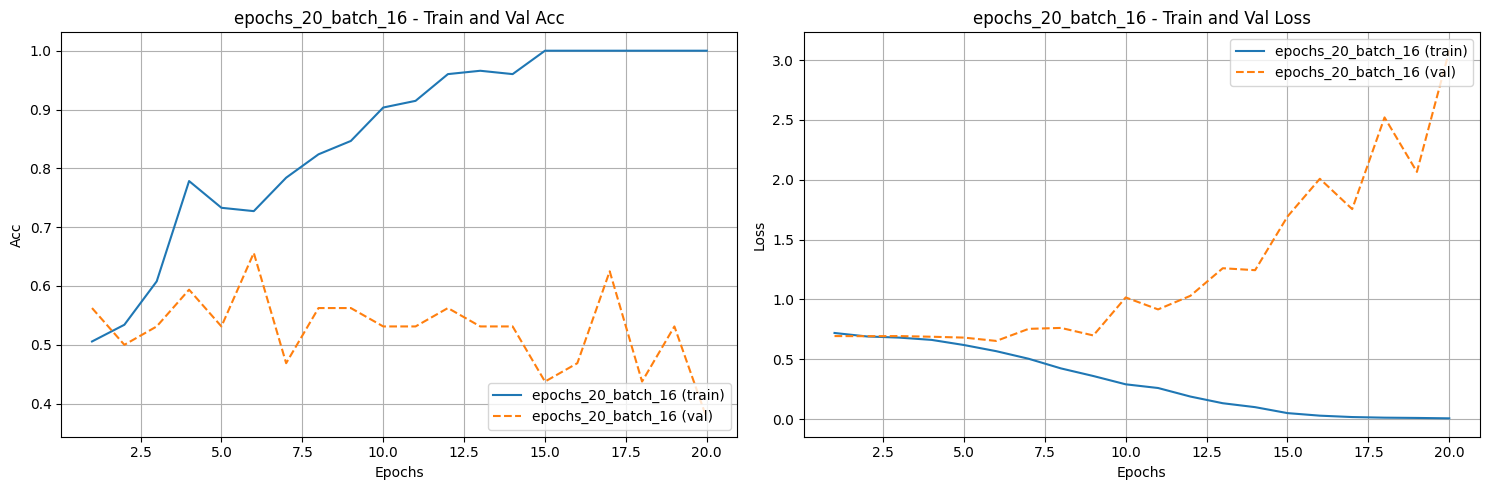

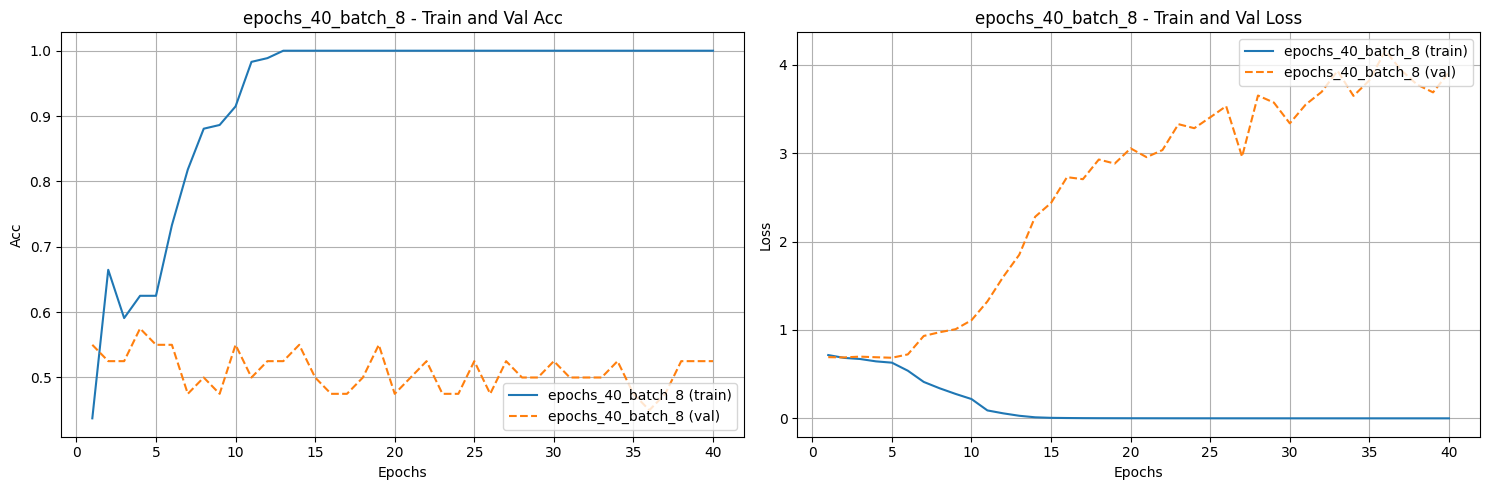

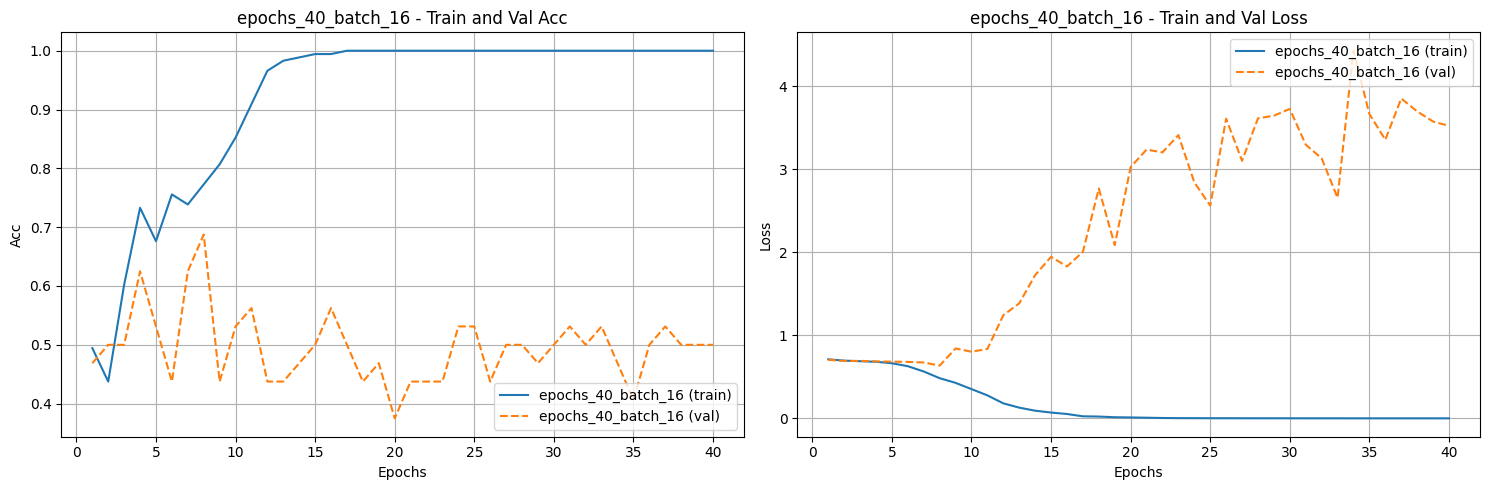

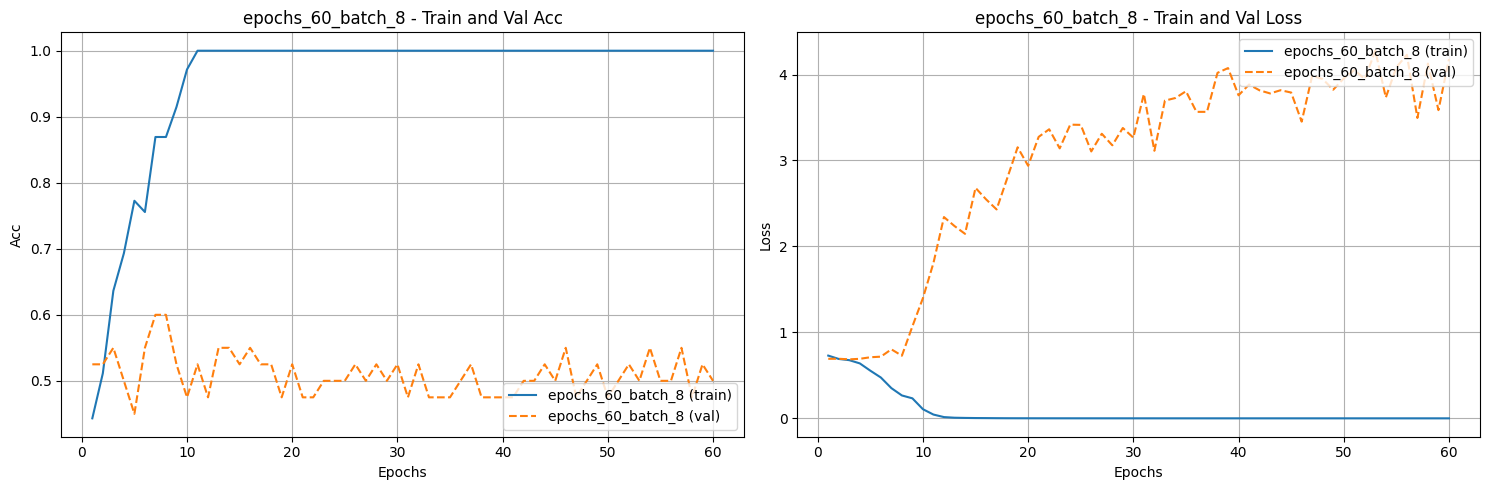

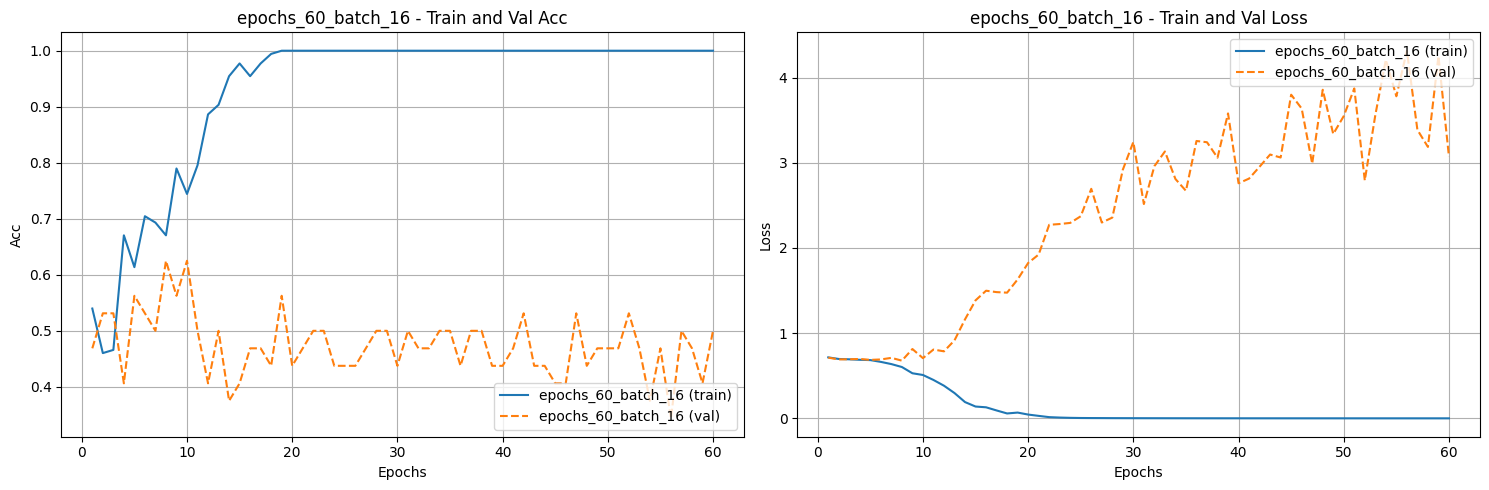

In [9]:
import matplotlib.pyplot as plt

for key, data in results.items():
    plt.figure(figsize=(15, 5))  # 調整圖的大小以適應單個組合

    # 繪製訓練和驗證準確率
    plt.subplot(1, 2, 1)  # 使用 1 行 2 列的子圖
    epochs_count = len(data['history']['accuracy'])
    epochs_range = range(1, epochs_count + 1)
    plt.plot(epochs_range, data['history']['accuracy'], '-', label=f"{key} (train)")
    if 'val_accuracy' in data['history']:
        plt.plot(epochs_range, data['history']['val_accuracy'], '--', label=f"{key} (val)")
    plt.title(f'{key} - Train and Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(loc='lower right')
    plt.grid(True)

    # 繪製訓練和驗證損失
    plt.subplot(1, 2, 2)
    epochs_count = len(data['history']['loss'])
    epochs_range = range(1, epochs_count + 1)
    plt.plot(epochs_range, data['history']['loss'], '-', label=f"{key} (train)")
    if 'val_loss' in data['history']:
        plt.plot(epochs_range, data['history']['val_loss'], '--', label=f"{key} (val)")
    plt.title(f'{key} - Train and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    filename = f'original_training_{key.replace(" ", "_")}.png'  # 創建包含參數組合名稱的文件名
    filepath = os.path.join(output_dir, filename)  # 組合路徑和檔名
    plt.savefig(filepath)
    print(f"參數組合 '{key}' 的訓練過程圖表已保存至: {filepath}")


print(f"\n所有參數組合的結果也已保存至: {csv_filename}, {detailed_csv_filename}, {summary_csv_filename}")

In [10]:
# 建立比較表格，以DataFrame方式顯示不同組合間的性能
comparison_table = pd.DataFrame({
    'Epochs_Batch': [key for key in results.keys()],
    'Test Acc': [results[key]['test_acc'] for key in results.keys()],
    'Train Acc': [results[key]['train_acc'] for key in results.keys()],
    'Val Acc': [results[key]['val_acc'] for key in results.keys()],
    'Test Loss': [results[key]['test_loss'] for key in results.keys()],
    'Train Loss': [results[key]['train_loss'] for key in results.keys()],
    'Val Loss': [results[key]['val_loss'] for key in results.keys()],
    'Training Time': [results[key]['formatted_time'] for key in results.keys()],
    'Overall Acc': [results[key]['overall_accuracy'] for key in results.keys()],
    'Men Acc': [results[key]['class_accuracies'].get('men', 0.0) for key in results.keys()],
    'Women Acc': [results[key]['class_accuracies'].get('women', 0.0) for key in results.keys()],
})
print("\n參數組合比較表:")
print(comparison_table.sort_values(by='Test Acc', ascending=False))


參數組合比較表:
         Epochs_Batch  Test Acc  Train Acc  Val Acc  Test Loss  Train Loss  \
4   epochs_60_batch_8    0.6125        1.0    0.500   2.992092    0.000044   
2   epochs_40_batch_8    0.6000        1.0    0.525   2.774516    0.000110   
5  epochs_60_batch_16    0.5750        1.0    0.500   3.272279    0.000260   
3  epochs_40_batch_16    0.5500        1.0    0.500   3.034517    0.000424   
1  epochs_20_batch_16    0.5375        1.0    0.375   2.033837    0.005734   
0   epochs_20_batch_8    0.5000        1.0    0.425   2.183687    0.001502   

   Val Loss Training Time  Overall Acc  Men Acc  Women Acc  
4  4.179776       0:10:47       0.6125    0.625      0.600  
2  3.914920       0:07:10       0.6000    0.575      0.625  
5  3.070210       0:10:35       0.5750    0.525      0.625  
3  3.525349       0:07:15       0.5500    0.550      0.550  
1  3.079024       0:03:39       0.5375    0.550      0.525  
0  3.650631       0:03:43       0.5000    0.475      0.525  
